In [1]:
# Import stuff: 
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sympy import Symbol
from sympy.solvers import solve

# This is for reasonable fontsize universally defined:
fs_label = 16
parameters = {                
                'figure.titlesize': fs_label+6,
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.linewidth': 5
             }
plt.rcParams.update(parameters)

names = ["Zygote", "Planula", "Cyst", "Polyp", "Medusa (juvenile)", "Medusa (mature)"]
cs = ["blue", "green", "red", "cyan", "magenta", "orange"]

xis = np.arange(0.00, 1, 0.005)
Ts = np.arange(0, 50, 0.1)


In [2]:

k = 1
T0 = 20
T_half = 2

xft = lambda T, k=k: k*T/(T+k)
tfx = lambda xi, k=k: k*xi/(k-xi)
#tfx = np.vectorize(tfx)
D = lambda d, T, T0=T0, T_half=25: d + (1-d)*(T-T0)**2/((T_half)**2+(T-T0)**2)
g = lambda d, t: (1-d)*(t-1)/t
h = lambda d, t: (1-d)/t

# Parameters: 
# TODO: use the real values
params_dict = dict(
    d1 = 0.8, # zygote
    d2 = 0.8, # planula
    d3 = 0.1, # cyst
    d4 = 0.5, # polyp
    d5 = 0.6, # medusa (juvenile)
    d6 = 0.6, # medusa (mature)
    t1 = 1,
    t2 = 2,
    t3 = 4,
    t4 = 4,
    t5 = 1,
    t6 = 4,
    phi = 250
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)

params_dict.update(
    g1 = g(d1, t1), # zygote
    g2 = g(d2, t2), # planula
    g3 = g(d3, t3), # cyst
    g4 = (1-d4), # *(t4-1)/t4, # polyp
    #g5 = (1-d5)*(t5-1)/t5, # medusa (juvenile)
    #g6 = (1-d6)*(t6-1)/t6, # medusa (mature)
    h12 = h(d1, t1), 
    h24 = h(d2, t2),  
    h34 = h(d3, t3), 
    h45 = (1-d4)*2, #/t4,  
    h53 = h(d5, t5), 
    h61 = h(d6, t6)
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)
    print(assign_str)
    
def evolve(L, xis):
    ss, gr, pvs = [], [], []
    eig_values_old, eig_vectors_old = None, None
    for i, xi in enumerate(xis):

        eig_values, eig_vectors = np.linalg.eig(L(xi))
        eig_vectors = eig_vectors.T
        isort = np.argsort([abs(z) for z in eig_values])
        if i != 0:
            closest = np.array([min(eig_values, key=lambda x: np.abs(x-m)) for m in eig_values_old])
            plot_vals = closest
        else:
            plot_vals = eig_values[isort] 
        pvs.append(plot_vals)
        gr.append(eig_values[isort][-1])
        ss.append(eig_vectors[isort][-1])
        eig_values_old, eig_vectors_old = plot_vals, eig_vectors[isort]
    return ss, gr, pvs


d1 = 0.8
d2 = 0.8
d3 = 0.1
d4 = 0.5
d5 = 0.6
d6 = 0.6
t1 = 1
t2 = 2
t3 = 4
t4 = 4
t5 = 1
t6 = 4
phi = 250
g1 = 0.0
g2 = 0.09999999999999998
g3 = 0.675
g4 = 0.5
h12 = 0.19999999999999996
h24 = 0.09999999999999998
h34 = 0.225
h45 = 1.0
h53 = 0.4
h61 = 0.1


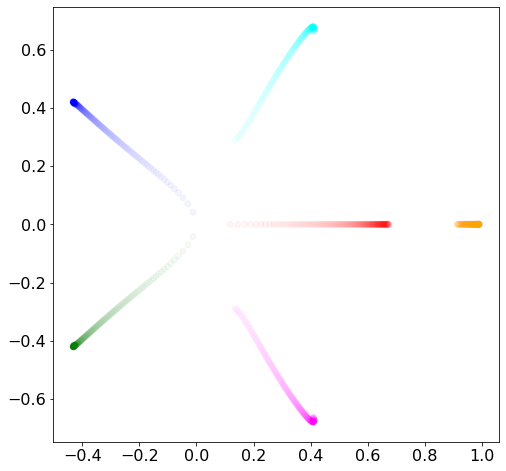

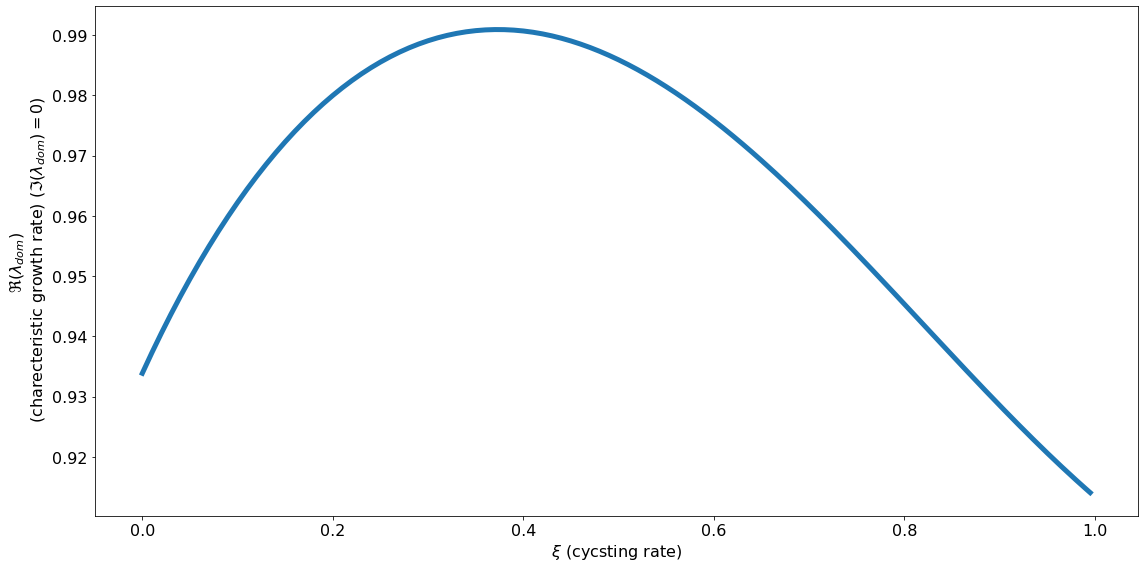

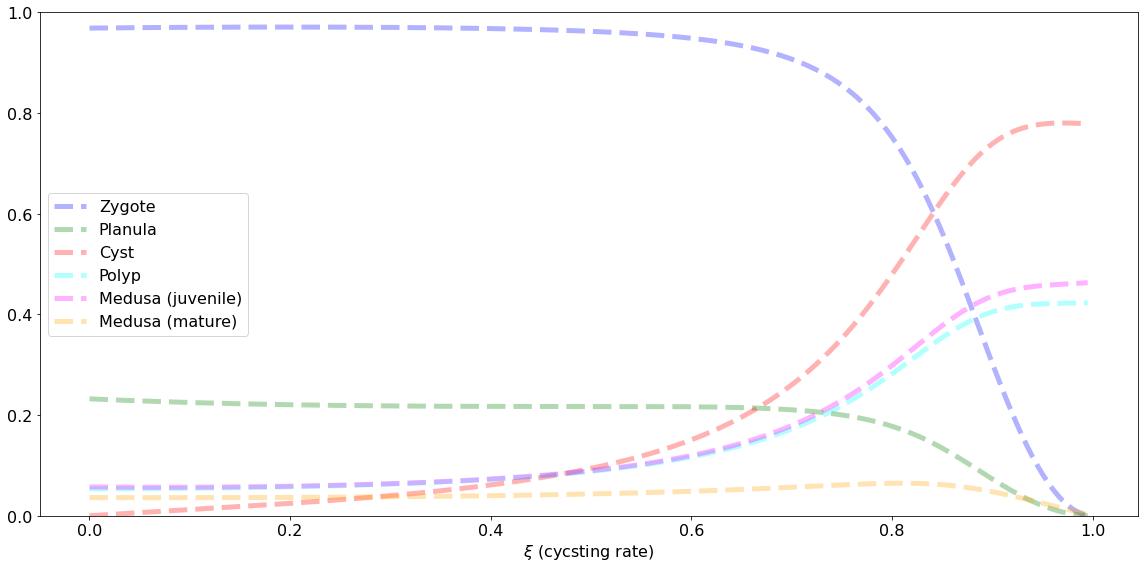

In [3]:
L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,                   phi*h(d6*(1-xi), t6)*(1-xi)], 
    [h12, g2,  0,   0,   0,                   0], 
    [0,   0,   g3,  0,   h53*xi,              g(d6*(1-xi), t6)*xi], 
    [0,   h24, h34, g4,  0,                   0], 
    [0,   0,   0,   h45, g(d5*(1-xi), t5)*(1-xi), 0], 
    [0,   0,   0,   0,   h(d5*(1-xi), t5)*(1-xi), g(d6*(1-xi), t6)*(1-xi)] #when they get high cysting they die less?
])

ss, gr, pvs = evolve(L, xis)

if True:
    fig, ax = plt.subplots(figsize=(8, 8))
    [ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04) for v in pvs]
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)
    ax.plot(xis, [e.real for e in gr])
    ax.set_xlabel("$\\xi$ (cycsting rate)")
    ax.set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate) ($\\Im(\\lambda_{{dom}})=0$)")
    plt.show()

    #fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)
    #ax.plot(xis, [e.imag for e in gr])
    #ax.set_xlabel("$\\xi$ (cycsting rate)")
    #ax.set_ylabel("$\\Im(\\lambda_{{dom}})$ \n (charecteristic osc. freq)")
    #plt.show()

    ss = np.array(ss)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
    for i, e in enumerate(ss.T):
        ax.plot(xis, abs(e), linestyle="--", marker="", label=names[i], color=cs[i], alpha=0.3)
    ax.set_ylim(0, 1)
    ax.set_xlabel("$\\xi$ (cycsting rate)")
    ax.legend()
    plt.show()


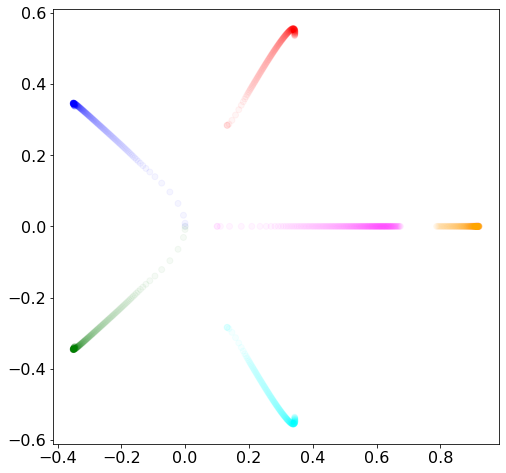

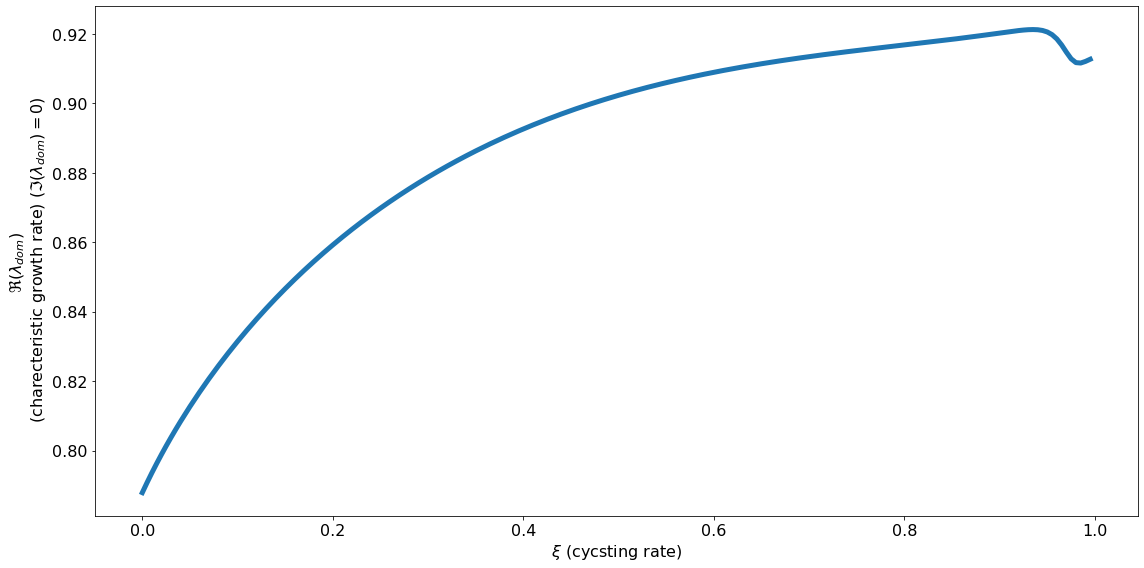

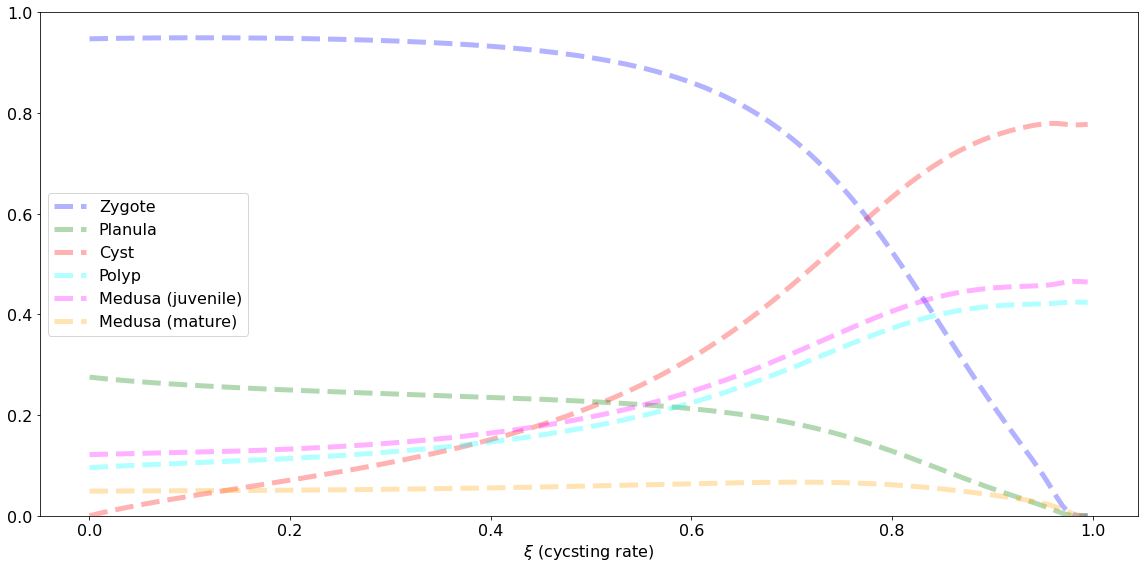

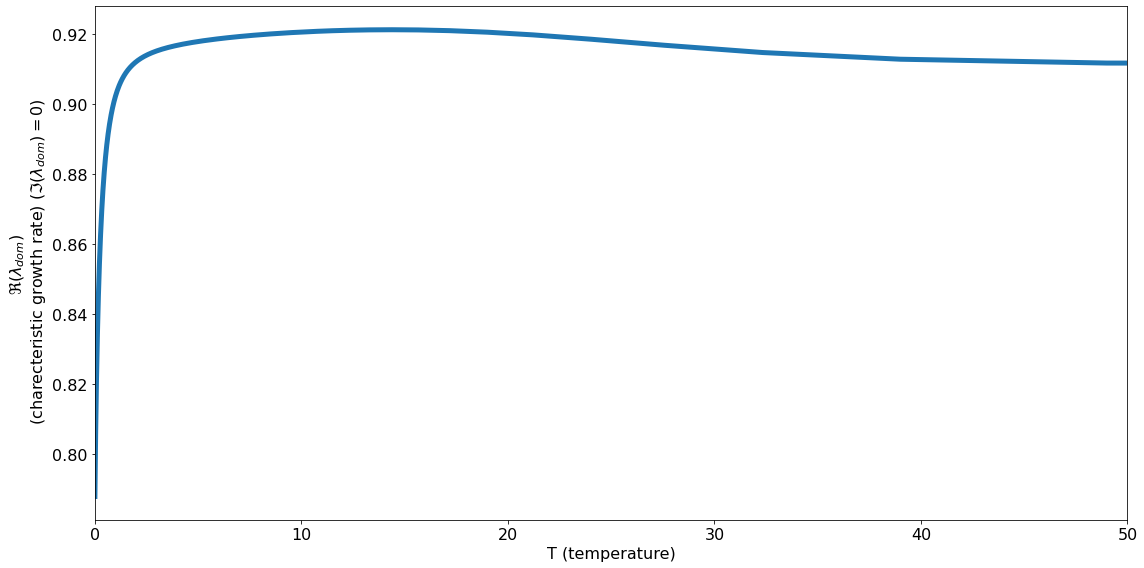

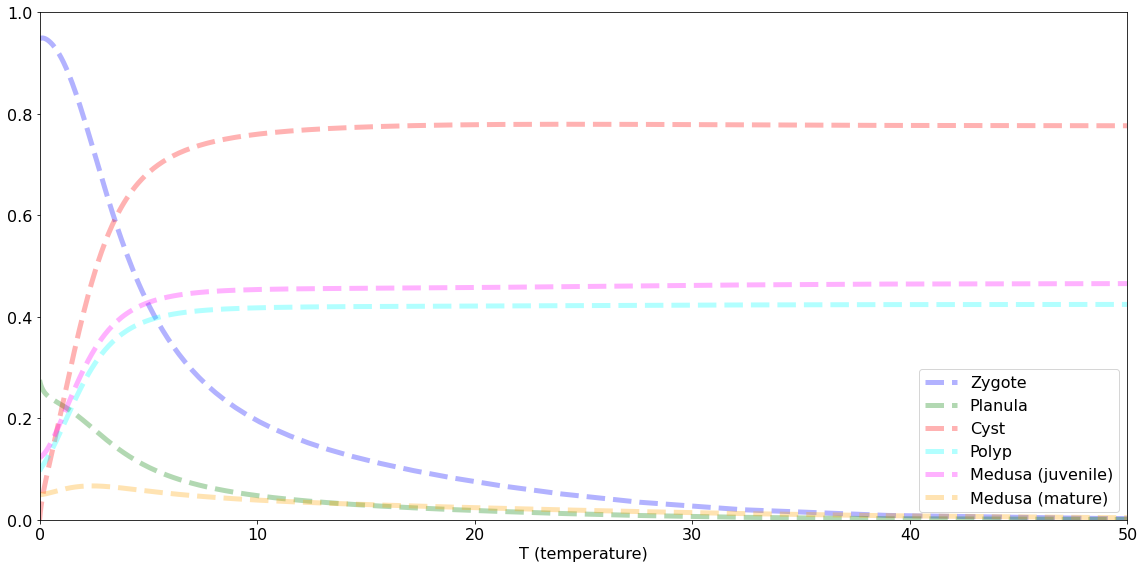

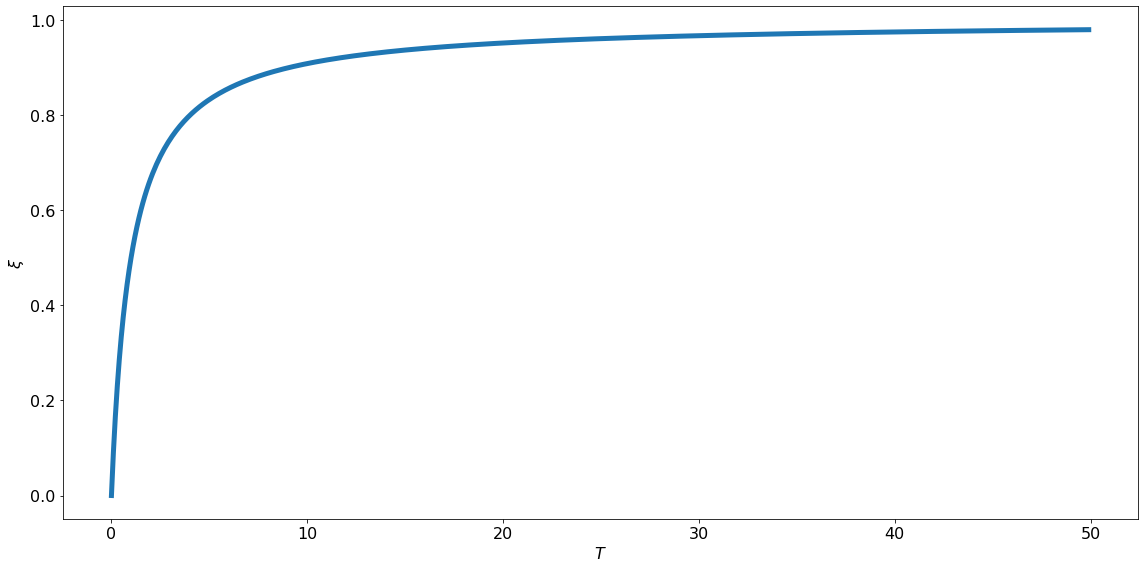

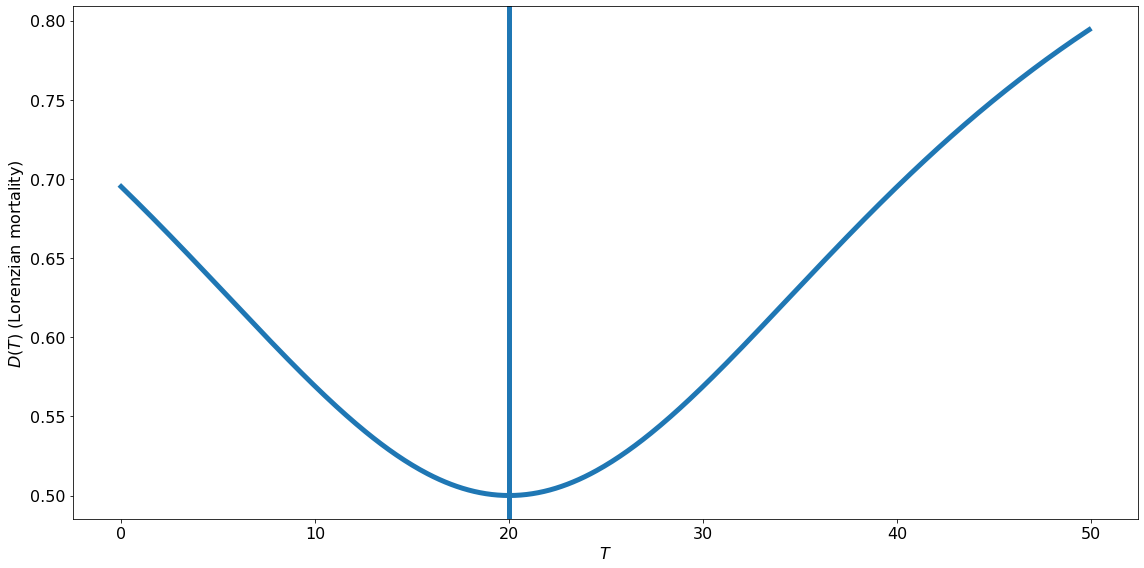

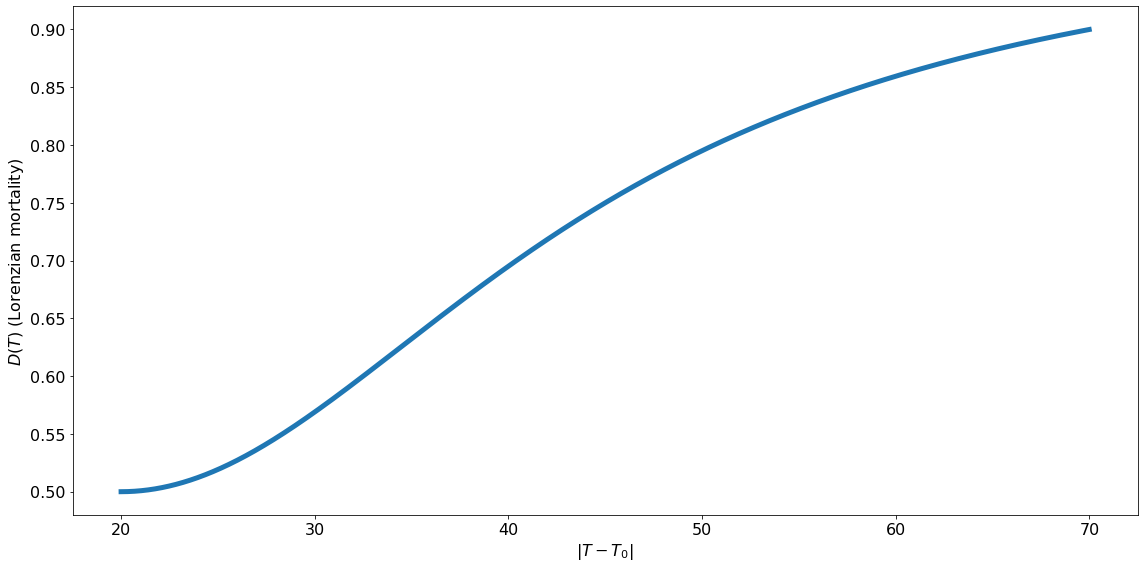

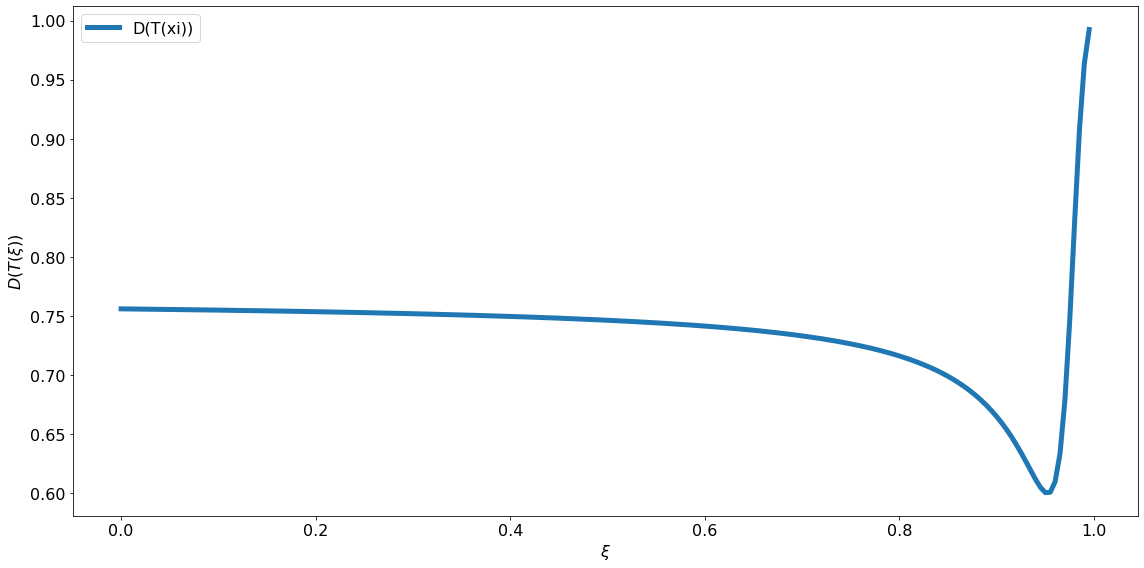

In [4]:
L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,                                   phi*h(D(d6*(1-xi), tfx(xi)), t6)*(1-xi)], 
    [h12, g2,  0,   0,   0,                                   0], 
    [0,   0,   g3,  0,   h53*xi,                              g(D(d6*(1-xi), tfx(xi)), t6)*xi], 
    [0,   h24, h34, g4,  0,                                   0], 
    [0,   0,   0,   h45, g(D(d5*(1-xi), tfx(xi)), t5)*(1-xi), 0], 
    [0,   0,   0,   0,   h(D(d5*(1-xi), tfx(xi)), t5)*(1-xi), g(D(d6*(1-xi), tfx(xi)), t6)*(1-xi)] #when they get high cysting they die less?
])

ss, gr, pvs = evolve(L, xis)

if True:
    fig, ax = plt.subplots(figsize=(8, 8))
    [ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04) for v in pvs]
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
    ax.plot(xis, [e.real for e in gr])
    ax.set_xlabel("$\\xi$ (cycsting rate)")
    ax.set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate) ($\\Im(\\lambda_{{dom}})=0$)")
    plt.show()

    ss = np.array(ss)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
    [ax.plot(xis, abs(e), linestyle="--", marker="", label=names[i], color=cs[i], alpha=0.3) for i, e in enumerate(ss.T)]
    ax.set_ylim(0, 1)
    ax.set_xlabel("$\\xi$ (cycsting rate)")
    ax.legend()

    fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
    ax.plot(tfx(xis), [e.real for e in gr])
    ax.set_xlabel("T (temperature)")
    ax.set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate) ($\\Im(\\lambda_{{dom}})=0$)")
    ax.set_xlim(0, 50)
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
    [ax.plot(tfx(xis), abs(e), linestyle="--", marker="", label=names[i], color=cs[i], alpha=0.3) for i, e in enumerate(ss.T)]
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 50)
    ax.set_xlabel("T (temperature)")
    ax.legend()
    plt.show()

#fig, ax = plt.subplots()
#ax.plot(xis, tfx(xis))
#ax.set_xlabel("xi")
#ax.set_ylabel("T")

fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax.plot(Ts, xft(Ts))
ax.set_xlabel("$T$")
ax.set_ylabel("$\\xi$")
#ax.set_xlim(0, 2)

fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax.plot(Ts, np.vectorize(D)(0.5, Ts))
ax.set_xlabel("$T$")
ax.set_ylabel("$D(T)$ (Lorenzian mortality)")
ax.axvline(T0, label="$T_{{0}}$")

Ts_tmp = np.arange(T0, T0+50, 0.01)
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax.plot(Ts_tmp, np.vectorize(D)(0.5, Ts_tmp))
ax.set_xlabel("$\\vert T-T_{{0}} \\vert$")
ax.set_ylabel("$D(T)$ (Lorenzian mortality)")
    
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax.plot(xis, np.vectorize(D)(d5, tfx(xis)), label="D(T(xi))")
ax.set_xlabel("$\\xi$")
ax.set_ylabel("$D(T(\\xi))$")
ax.legend()


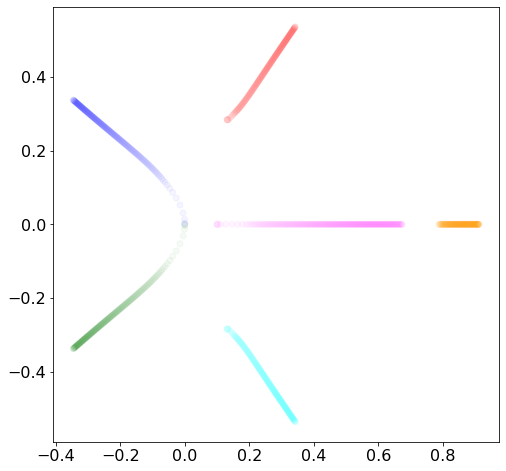

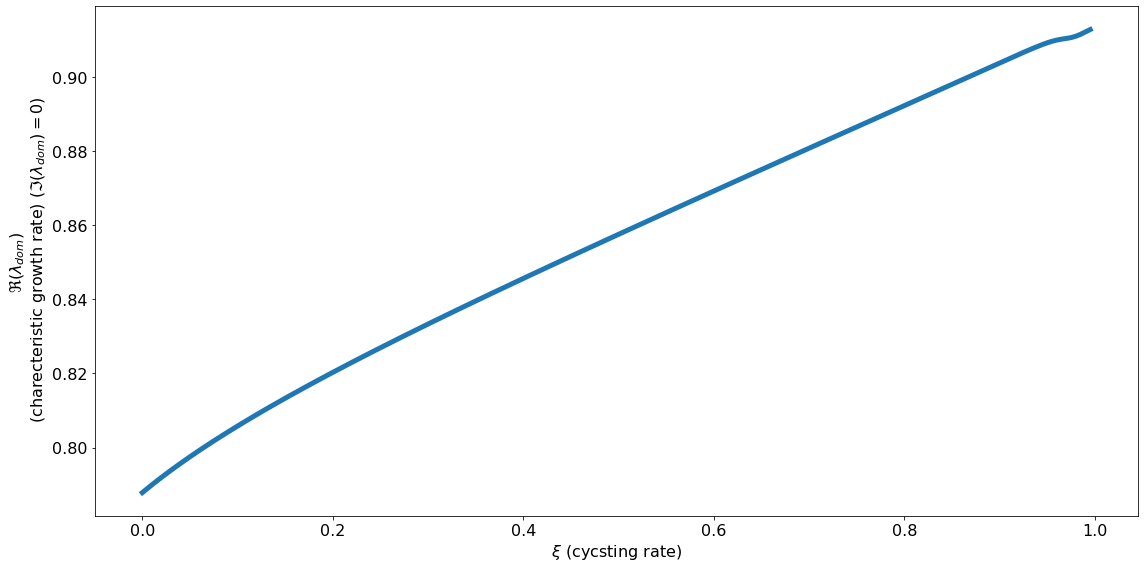

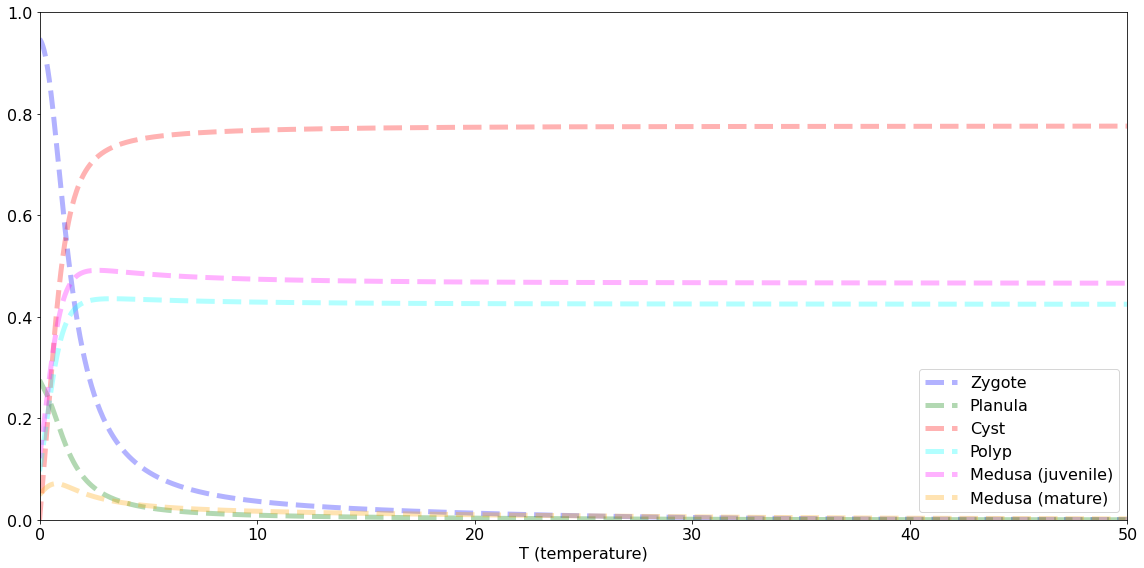

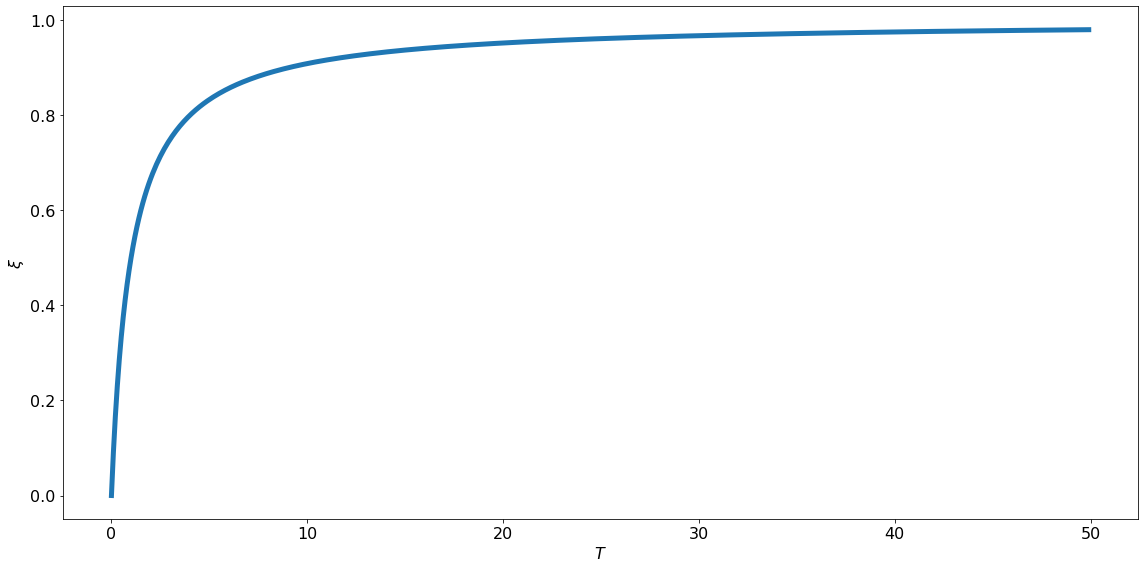

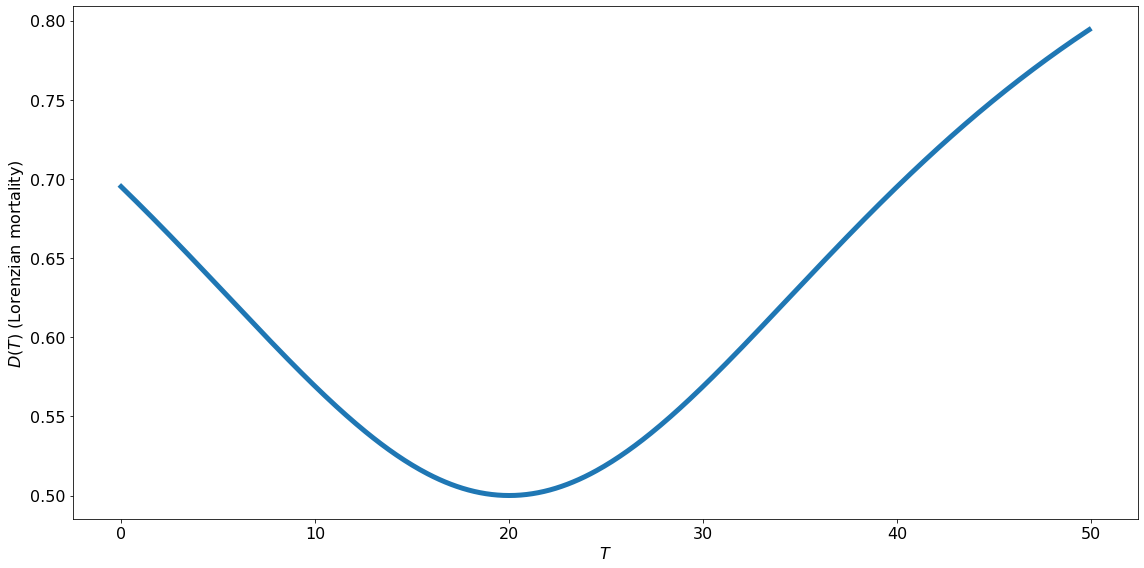

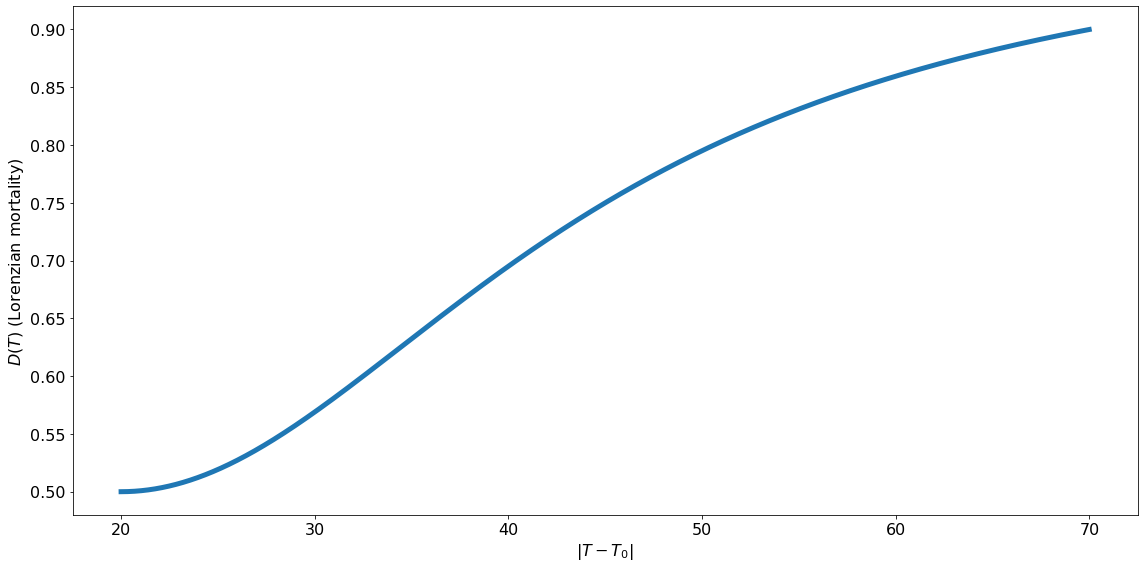

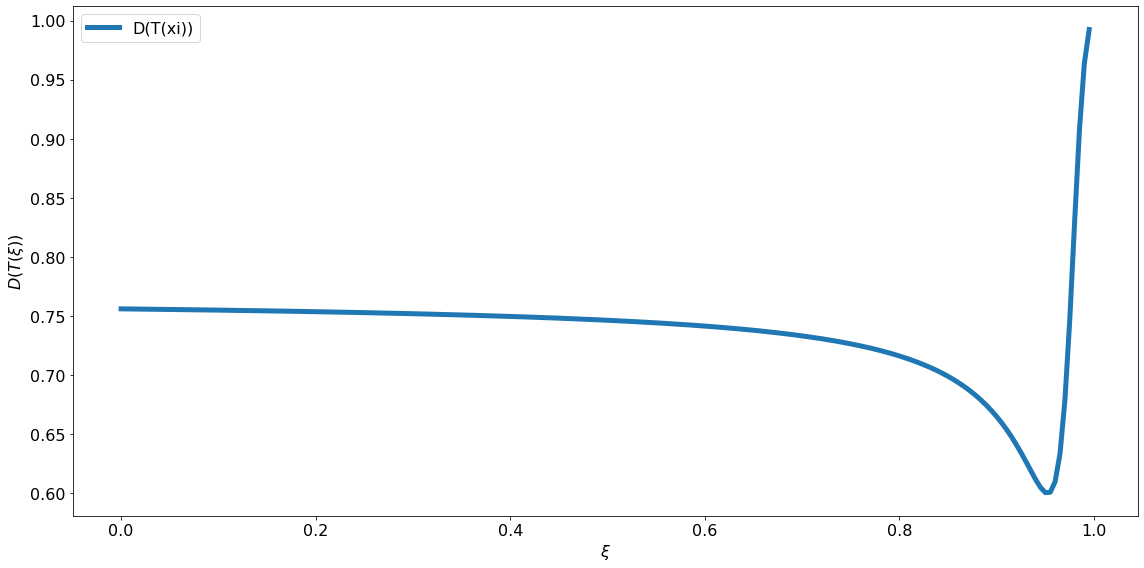

In [5]:
L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,                            phi*h(D(d6, tfx(xi)), t6)*(1-xi)], 
    [h12, g2,  0,   0,   0,                            0], 
    [0,   0,   g3,  0,   h53*xi,                       g(D(d6, tfx(xi)), t6)*xi], 
    [0,   h24, h34, g4,  0,                            0], 
    [0,   0,   0,   h45, g(D(d5, tfx(xi)), t5)*(1-xi), 0], 
    [0,   0,   0,   0,   h(D(d5, tfx(xi)), t5)*(1-xi), g(D(d6, tfx(xi)), t6)*(1-xi)] #when they get high cysting they die less?
])

ss, gr, pvs = evolve(L, xis)

if True:
    fig, ax = plt.subplots(figsize=(8, 8))
    [ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04) for v in pvs]
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
    ax.plot(xis, [e.real for e in gr])
    ax.set_xlabel("$\\xi$ (cycsting rate)")
    ax.set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate) ($\\Im(\\lambda_{{dom}})=0$)")
    plt.show()
    
#    fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
#    ax.plot(xis, [e.imag for e in gr])
#    ax.set_xlabel("$\\xi$ (cycsting rate)")
#    ax.set_ylabel("$\\Im(\\lambda_{{dom}})$ \n (charecteristic osc. freq)")
#    plt.show()

    ss = np.array(ss)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
    [ax.plot(tfx(xis), abs(e), linestyle="--", marker="", label=names[i], color=cs[i], alpha=0.3) for i, e in enumerate(ss.T)]
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 50)

    ax.set_xlabel("T (temperature)")
    #ax.set_xlabel("$\\xi$ (cycsting rate)")
    ax.legend()
    plt.show()

#fig, ax = plt.subplots()
#ax.plot(xis, tfx(xis))
#ax.set_xlabel("xi")
#ax.set_ylabel("T")

fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax.plot(Ts, xft(Ts))
ax.set_xlabel("$T$")
ax.set_ylabel("$\\xi$")
#ax.set_xlim(0, 2)

fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax.plot(Ts, np.vectorize(D)(0.5, Ts))
ax.set_xlabel("$T$")
ax.set_ylabel("$D(T)$ (Lorenzian mortality)")

Ts_tmp = np.arange(T0, T0+50, 0.01)
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax.plot(Ts_tmp, np.vectorize(D)(0.5, Ts_tmp))
ax.set_xlabel("$\\vert T-T_{{0}} \\vert$")
ax.set_ylabel("$D(T)$ (Lorenzian mortality)")
    
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax.plot(xis, np.vectorize(D)(d5, tfx(xis)), label="D(T(xi))")
ax.set_xlabel("$\\xi$")
ax.set_ylabel("$D(T(\\xi))$")
ax.legend()


# Olde code; ye who enters here, abandon all hope!

In [6]:
# Parameters: 
# TODO: use the real values
params_dict = dict(
    d1 = 0.8, # zygote
    d2 = 0.8, # planula
    d3 = 0.1,
    d4 = 0.5,
    d5 = 0.5,
    d6 = 0.4,
    t1 = 1,
    t2 = 2,
    t3 = 4,
    t4 = 4,
    t5 = 1,
    t6 = 4,
    phi = 80, 
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)

params_dict.update(
    g1 = (1-d2)*(t1-1)/t1, # zygote
    g2 = (1-d2)*(t2-1)/t2, # planula
    g3 = (1-d3)*(t3-1)/t3, # cyst
    g4 = (1-d4), # *(t4-1)/t4, # polyp
    g5 = (1-d5)*(t5-1)/t5, # medusa (juvenile)
    g6 = (1-d6)*(t6-1)/t6, # medusa (mature)
    h12 = (1-d1)/t1, 
    h24 = (1-d2)/t2,  
    h34 = (1-d3)/t3, 
    h45 = (1-d4)*2, #/t4,  
    h56 = (1-d5)/t5  
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)
    print(assign_str)
    
names = ["Zygote", "Planula", "Cyst", "Polyp", "Medusa (juvenile)", "Medusa (mature)"]

d1 = 0.8
d2 = 0.8
d3 = 0.1
d4 = 0.5
d5 = 0.5
d6 = 0.4
t1 = 1
t2 = 2
t3 = 4
t4 = 4
t5 = 1
t6 = 4
phi = 80
g1 = 0.0
g2 = 0.09999999999999998
g3 = 0.675
g4 = 0.5
g5 = 0.0
g6 = 0.44999999999999996
h12 = 0.19999999999999996
h24 = 0.09999999999999998
h34 = 0.225
h45 = 1.0
h56 = 0.5


In [7]:
L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,          phi*(1-d6)*(1/t6)*(1-xi)], 
    [h12, g2,  0,   0,   0,          0], 
    [0,   0,   g3,  0,   (1-d5)*xi,  (1-d6)*xi], 
    [0,   h24, h34, g4,  0,          0], 
    [0,   0,   0,   h45, g5*(1-xi),  0], 
    [0,   0,   0,   0,   h56*(1-xi), g6*(1-xi)]
])

#L = lambda xi: np.array([
#    [g1,  0,   0,   0,   0,          phi*(1-d6*xi)*(1/t6)*(1-xi)], 
#    [h12, g2,  0,   0,   0,          0], 
#    [0,   0,   g3,  0,   (1-d5*xi)*xi,  (1-d6*xi)*xi], 
#    [0,   h24, h34, g4,  0,          0], 
#    [0,   0,   0,   h45, (1-d5*xi)*(t5-1)/t5*(1-xi),  0], 
#    [0,   0,   0,   0,   (1-d5*xi)/t5*(1-xi), (1-d6*xi)*(t6-1)/t6*(1-xi)]
#])

(1-d2)*(t1-1)/t1

cs = ["blue", "green", "red", "cyan", "magenta", "orange"]
ss = []
gr = []
pvs = []
xis = np.arange(0.00, 1, 0.005)
#fig, ax = plt.subplots()
eig_values_old, eig_vectors_old = None, None
for i, xi in enumerate(xis):
    
    eig_values, eig_vectors = np.linalg.eig(L(xi))
    eig_vectors = eig_vectors.T
    isort = np.argsort([abs(z) for z in eig_values])
    if i != 0:
        closest = np.array([min(eig_values, key=lambda x: np.abs(x-m)) for m in eig_values_old])
        plot_vals = closest
    else:
        plot_vals = eig_values[isort] 
    #print(eig_vectors[isort][-1])
    #plot_vals = (i==0)*eig_values[isort] + (i!=0)*closest
    #[ax.scatter(xi, abs(j)) for j in eig_values[isort]]
    pvs.append(plot_vals)
    gr.append(eig_values[isort][-1])
    ss.append(eig_vectors[isort][-1])
    eig_values_old, eig_vectors_old = plot_vals, eig_vectors[isort]



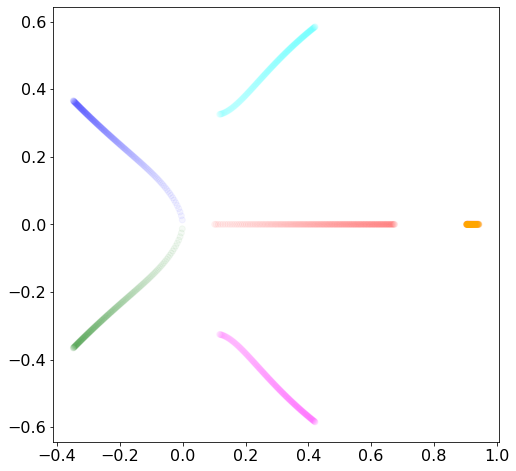

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
for v in pvs:
    ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04)

Text(0, 0.5, '$\\Im(\\lambda_{{dom}})$ \n (charecteristic osc. freq)')

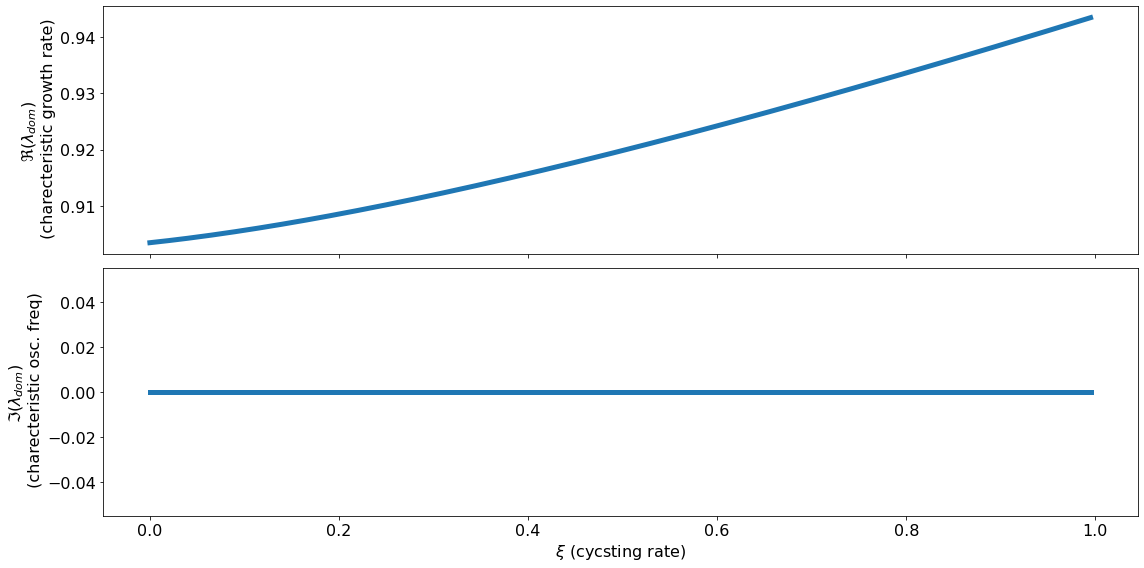

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax[0].plot(xis, [e.real for e in gr])
ax[1].plot(xis, [e.imag for e in gr])

ax[1].set_xlabel("$\\xi$ (cycsting rate)")
ax[0].set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate)")
ax[1].set_ylabel("$\\Im(\\lambda_{{dom}})$ \n (charecteristic osc. freq)")


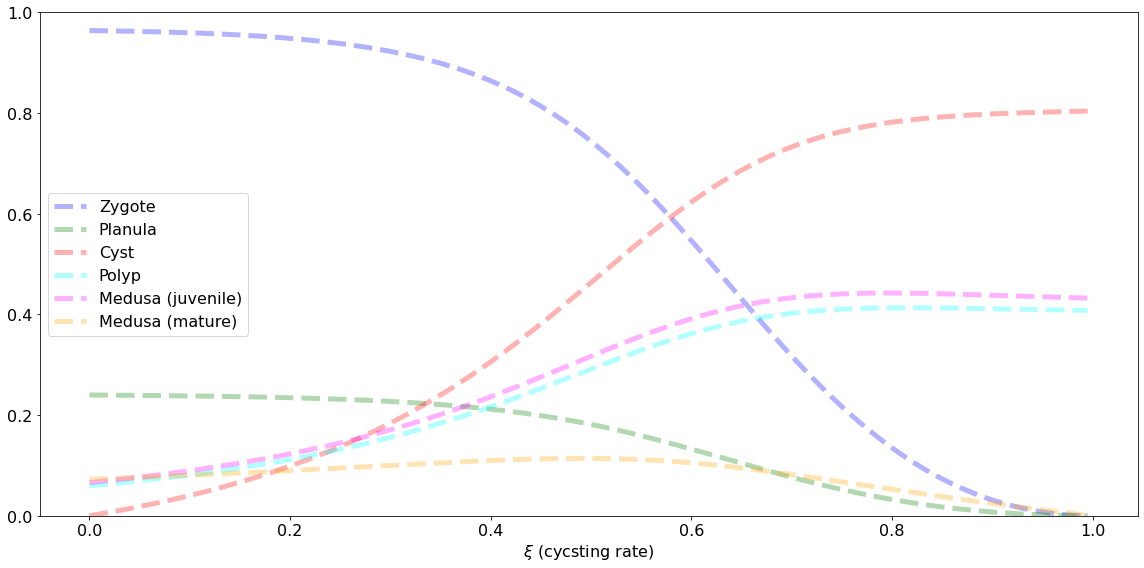

In [10]:
ss = np.array(ss)
#ax[1].plot(*list(zip(*[(z.real, z.imag) for z in ss.T])))
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
for i, e in enumerate(ss.T):
    ax.plot(xis, abs(e), linestyle="--", marker="", label=names[i], color=cs[i], alpha=0.3)
ax.set_ylim(0, 1)
ax.set_xlabel("$\\xi$ (cycsting rate)")
ax.legend()


d1 = 0.8
d2 = 0.8
d3 = 0.1
d4 = 0.5
d5 = 0.6
d6 = 0.6
t1 = 1
t2 = 2
t3 = 4
t4 = 4
t5 = 1
t6 = 4
phi = 250
g1 = 0.0
g2 = 0.09999999999999998
g3 = 0.675
g4 = 0.5
g5 = 0.0
g6 = 0.30000000000000004
h12 = 0.19999999999999996
h24 = 0.09999999999999998
h34 = 0.225
h45 = 1.0
h56 = 0.4
h53 = 0.4
h63 = 0.4
h61 = 0.1


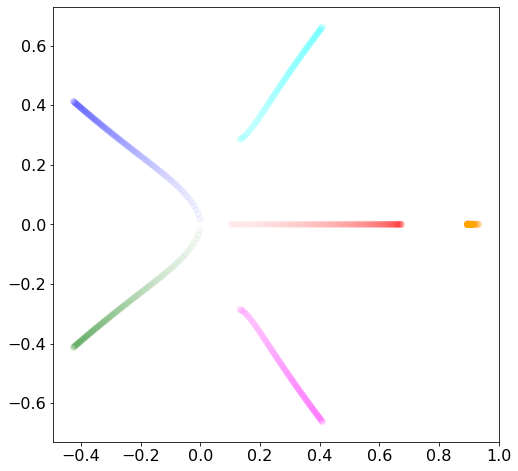

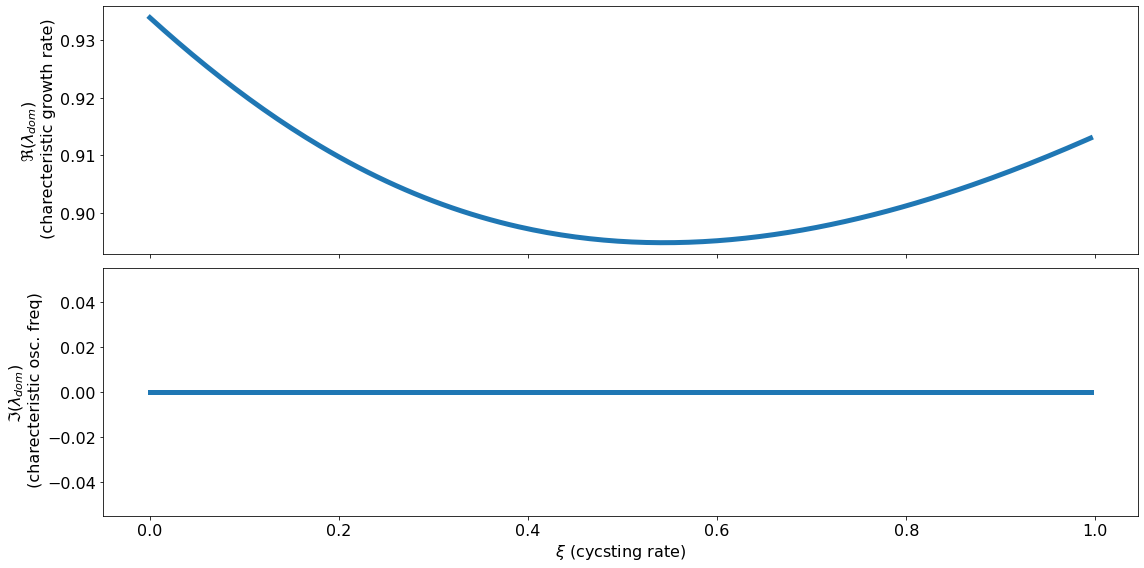

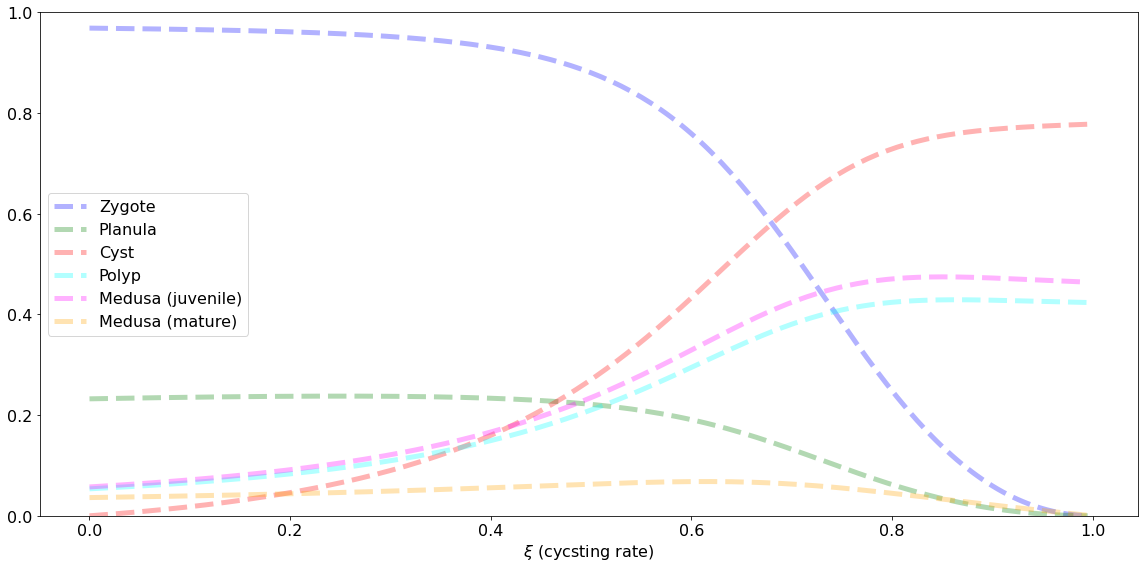

In [11]:
# Parameters: 
# TODO: use the real values
params_dict = dict(
    d1 = 0.8, # zygote
    d2 = 0.8, # planula
    d3 = 0.1,
    d4 = 0.5,
    d5 = 0.6,
    d6 = 0.6,
    t1 = 1,
    t2 = 2,
    t3 = 4,
    t4 = 4,
    t5 = 1,
    t6 = 4,
    phi = 250, 
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)

params_dict.update(
    g1 = (1-d2)*(t1-1)/t1, # zygote
    g2 = (1-d2)*(t2-1)/t2, # planula
    g3 = (1-d3)*(t3-1)/t3, # cyst
    g4 = (1-d4), # *(t4-1)/t4, # polyp
    g5 = (1-d5)*(t5-1)/t5, # medusa (juvenile)
    g6 = (1-d6)*(t6-1)/t6, # medusa (mature)
    h12 = (1-d1)/t1, 
    h24 = (1-d2)/t2,  
    h34 = (1-d3)/t3, 
    h45 = (1-d4)*2, #/t4,  
    h56 = (1-d5)/t5,
    h53 = (1-d5),
    h63 = (1-d6),
    h61 = (1-d6)/t6
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)
    print(assign_str)
    
names = ["Zygote", "Planula", "Cyst", "Polyp", "Medusa (juvenile)", "Medusa (mature)"]


L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,          phi*h61*(1-xi)], 
    [h12, g2,  0,   0,   0,          0], 
    [0,   0,   g3,  0,   h53*xi,     h63*xi], 
    [0,   h24, h34, g4,  0,          0], 
    [0,   0,   0,   h45, g5*(1-xi),  0], 
    [0,   0,   0,   0,   h56*(1-xi), g6*(1-xi)]
])

#L = lambda xi: np.array([
#    [g1,  0,   0,   0,   0,          phi*(1-d6*xi)*(1/t6)*(1-xi)], 
#    [h12, g2,  0,   0,   0,          0], 
#    [0,   0,   g3,  0,   (1-d5*xi)*xi,  (1-d6*xi)*xi], 
#    [0,   h24, h34, g4,  0,          0], 
#    [0,   0,   0,   h45, (1-d5*xi)*(t5-1)/t5*(1-xi),  0], 
#    [0,   0,   0,   0,   (1-d5*xi)/t5*(1-xi), (1-d6*xi)*(t6-1)/t6*(1-xi)]
#])

(1-d2)*(t1-1)/t1

cs = ["blue", "green", "red", "cyan", "magenta", "orange"]
ss = []
gr = []
pvs = []
xis = np.arange(0.00, 1, 0.005)
#fig, ax = plt.subplots()
eig_values_old, eig_vectors_old = None, None
for i, xi in enumerate(xis):
    
    eig_values, eig_vectors = np.linalg.eig(L(xi))
    eig_vectors = eig_vectors.T
    isort = np.argsort([abs(z) for z in eig_values])
    if i != 0:
        closest = np.array([min(eig_values, key=lambda x: np.abs(x-m)) for m in eig_values_old])
        plot_vals = closest
    else:
        plot_vals = eig_values[isort] 
    pvs.append(plot_vals)
    gr.append(eig_values[isort][-1])
    ss.append(eig_vectors[isort][-1])
    eig_values_old, eig_vectors_old = plot_vals, eig_vectors[isort]

fig, ax = plt.subplots(figsize=(8, 8))
for v in pvs:
    ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04)
plt.show()




fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax[0].plot(xis, [e.real for e in gr])
ax[1].plot(xis, [e.imag for e in gr])

ax[1].set_xlabel("$\\xi$ (cycsting rate)")
ax[0].set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate)")
ax[1].set_ylabel("$\\Im(\\lambda_{{dom}})$ \n (charecteristic osc. freq)")
plt.show()




ss = np.array(ss)
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
for i, e in enumerate(ss.T):
    ax.plot(xis, abs(e), linestyle="--", marker="", label=names[i], color=cs[i], alpha=0.3)
ax.set_ylim(0, 1)
ax.set_xlabel("$\\xi$ (cycsting rate)")
ax.legend()
plt.show()

d1 = 0.8
d2 = 0.8
d3 = 0.1
d4 = 0.3
d5 = 0.6
d6 = 0.6
t1 = 1
t2 = 2
t3 = 4
t4 = 4
t5 = 1
t6 = 4
phi = 100
g1 = 0.0
g2 = 0.09999999999999998
g3 = 0.675
g4 = 0.7
g5 = 0.0
g6 = 0.30000000000000004
h12 = 0.19999999999999996
h24 = 0.09999999999999998
h34 = 0.225
h45 = 0.175
h56 = 0.4
h53 = 0.4
h63 = 0.4
h61 = 0.1


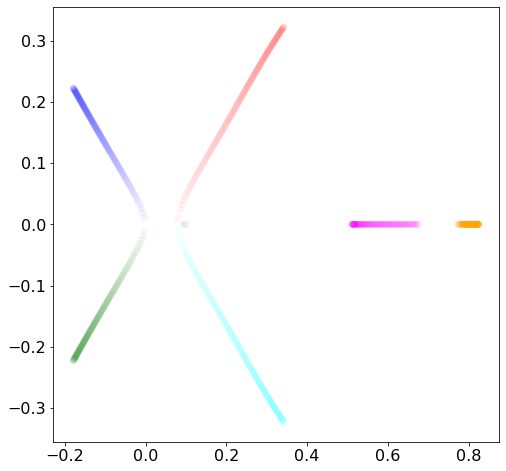

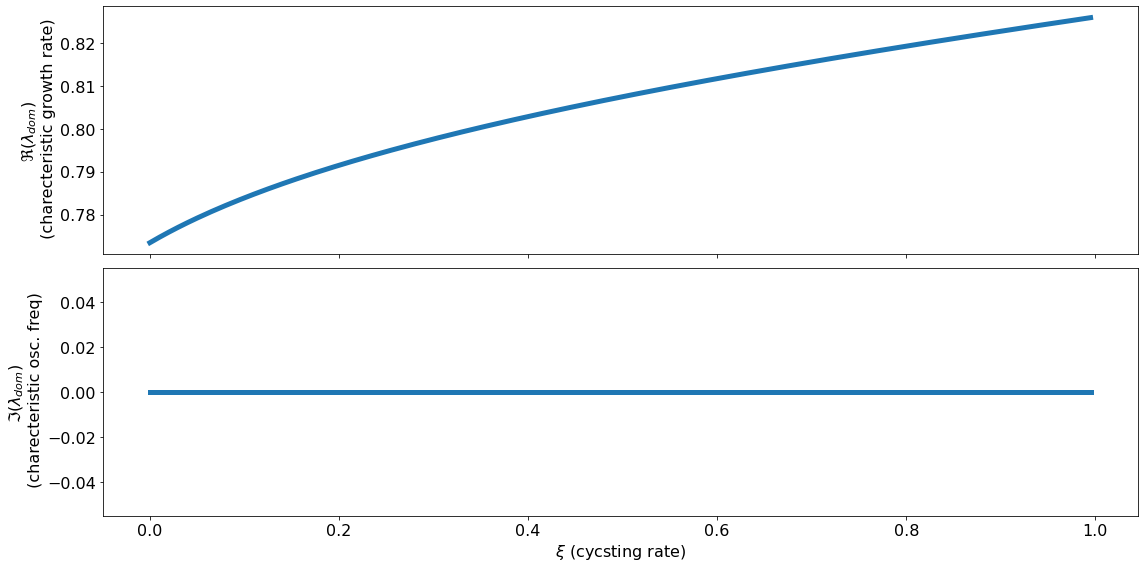

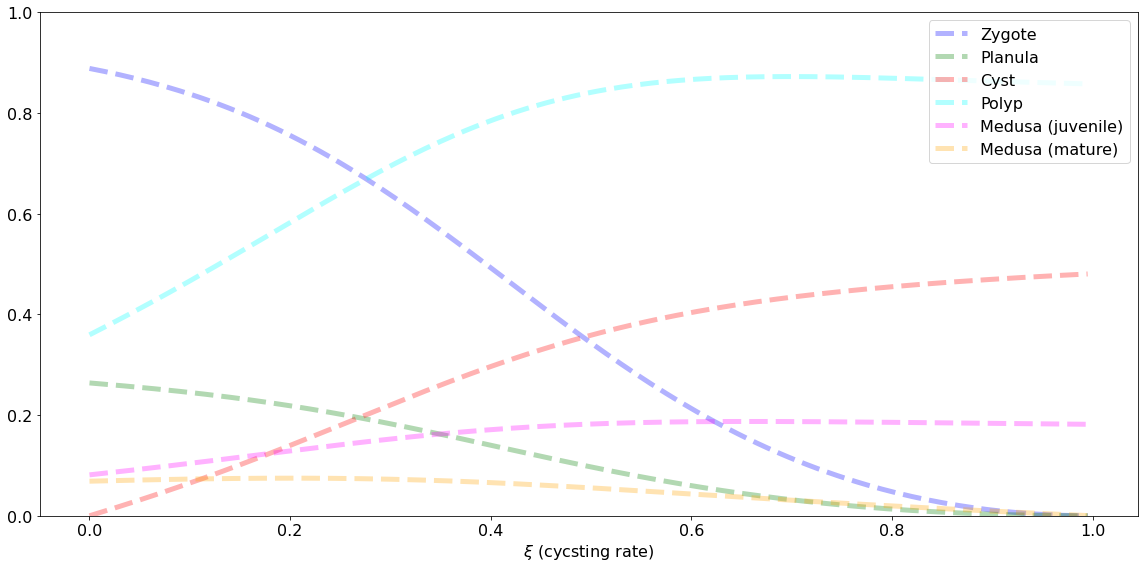

In [12]:
# Parameters: 
# TODO: use the real values
params_dict = dict(
    d1 = 0.8, # zygote
    d2 = 0.8, # planula
    d3 = 0.1,
    d4 = 0.3,
    d5 = 0.6,
    d6 = 0.6,
    t1 = 1,
    t2 = 2,
    t3 = 4,
    t4 = 4,
    t5 = 1,
    t6 = 4,
    phi = 100, 
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)

params_dict.update(
    g1 = (1-d1)*(t1-1)/t1, # zygote
    g2 = (1-d2)*(t2-1)/t2, # planula
    g3 = (1-d3)*(t3-1)/t3, # cyst
    g4 = (1-d4), # *(t4-1)/t4, # polyp
    g5 = (1-d5)*(t5-1)/t5, # medusa (juvenile)
    g6 = (1-d6)*(t6-1)/t6, # medusa (mature)
    h12 = (1-d1)/t1, 
    h24 = (1-d2)/t2,  
    h34 = (1-d3)/t3, 
    h45 = (1-d4)/4, #/t4,  
    h56 = (1-d5)/t5,
    h53 = (1-d5),
    h63 = (1-d6),
    h61 = (1-d6)/t6
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)
    print(assign_str)
    
names = ["Zygote", "Planula", "Cyst", "Polyp", "Medusa (juvenile)", "Medusa (mature)"]


L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,          phi*h61*(1-xi)], 
    [h12, g2,  0,   0,   0,          0], 
    [0,   0,   g3,  0,   h53*xi,     h63*xi], 
    [0,   h24, h34, g4,  0,          0], 
    [0,   0,   0,   h45, g5*(1-xi),  0], 
    [0,   0,   0,   0,   h56*(1-xi), g6*(1-xi)]
])

#L = lambda xi: np.array([
#    [g1,  0,   0,   0,   0,          phi*(1-d6*xi)*(1/t6)*(1-xi)], 
#    [h12, g2,  0,   0,   0,          0], 
#    [0,   0,   g3,  0,   (1-d5*xi)*xi,  (1-d6*xi)*xi], 
#    [0,   h24, h34, g4,  0,          0], 
#    [0,   0,   0,   h45, (1-d5*xi)*(t5-1)/t5*(1-xi),  0], 
#    [0,   0,   0,   0,   (1-d5*xi)/t5*(1-xi), (1-d6*xi)*(t6-1)/t6*(1-xi)]
#])

(1-d2)*(t1-1)/t1

cs = ["blue", "green", "red", "cyan", "magenta", "orange"]
ss = []
gr = []
pvs = []
xis = np.arange(0.00, 1, 0.005)
#fig, ax = plt.subplots()
eig_values_old, eig_vectors_old = None, None
for i, xi in enumerate(xis):
    
    eig_values, eig_vectors = np.linalg.eig(L(xi))
    eig_vectors = eig_vectors.T
    isort = np.argsort([abs(z) for z in eig_values])
    if i != 0:
        closest = np.array([min(eig_values, key=lambda x: np.abs(x-m)) for m in eig_values_old])
        plot_vals = closest
    else:
        plot_vals = eig_values[isort] 
    pvs.append(plot_vals)
    gr.append(eig_values[isort][-1])
    ss.append(eig_vectors[isort][-1])
    eig_values_old, eig_vectors_old = plot_vals, eig_vectors[isort]

fig, ax = plt.subplots(figsize=(8, 8))
for v in pvs:
    ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04)
plt.show()




fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax[0].plot(xis, [e.real for e in gr])
ax[1].plot(xis, [e.imag for e in gr])

ax[1].set_xlabel("$\\xi$ (cycsting rate)")
ax[0].set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate)")
ax[1].set_ylabel("$\\Im(\\lambda_{{dom}})$ \n (charecteristic osc. freq)")
plt.show()




ss = np.array(ss)
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
for i, e in enumerate(ss.T):
    ax.plot(xis, abs(e), linestyle="--", marker="", label=names[i], color=cs[i], alpha=0.3)
ax.set_ylim(0, 1)
ax.set_xlabel("$\\xi$ (cycsting rate)")
ax.legend()
plt.show()

d1 = 0.8
d2 = 0.8
d3 = 0.1
d4 = 0.3
d5 = 0.6
d6 = 0.6
t1 = 1
t2 = 2
t3 = 4
t4 = 4
t5 = 1
t6 = 4
phi = 150
g1 = 0.0
g2 = 0.09999999999999998
g3 = 0.675
g4 = 0.7
g5 = 0.0
g6 = 0.30000000000000004
h12 = 0.19999999999999996
h24 = 0.09999999999999998
h34 = 0.225
h45 = 0.175
h56 = 0.4
h53 = 0.4
h63 = 0.4
h61 = 0.1
dx = 0.5


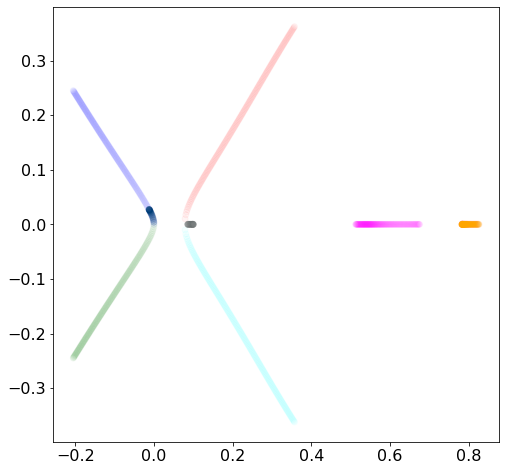

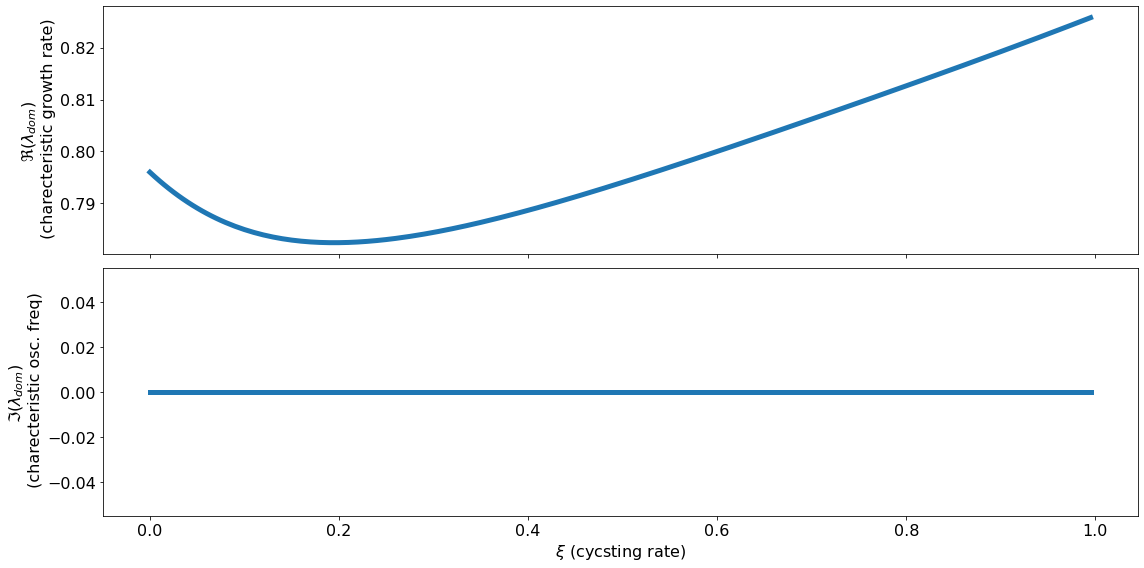

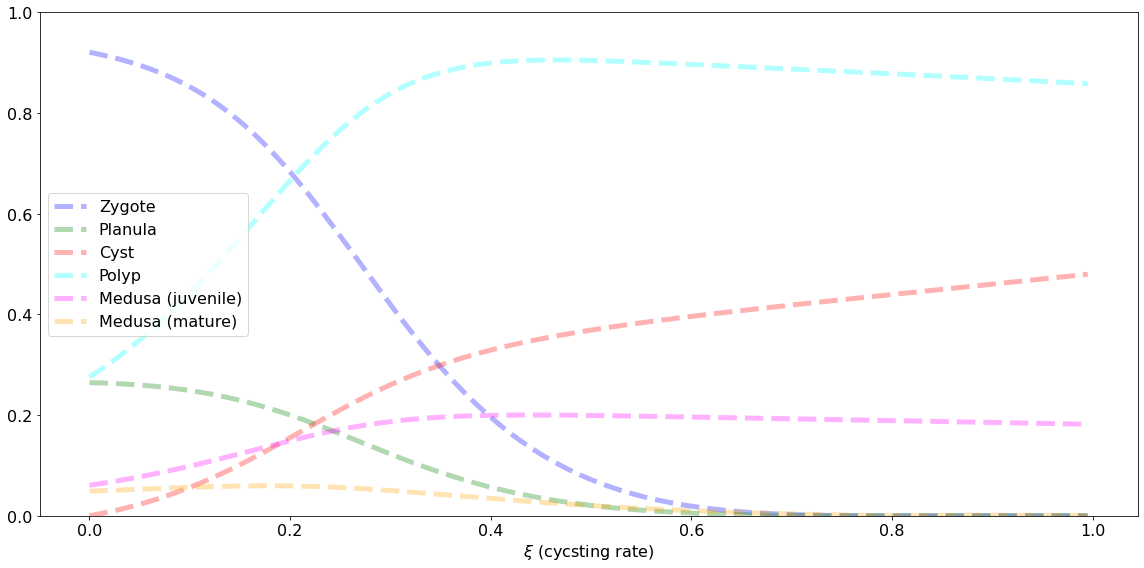

In [13]:
# Parameters: 
# TODO: use the real values
params_dict = dict(
    d1 = 0.8, # zygote
    d2 = 0.8, # planula
    d3 = 0.1,
    d4 = 0.3,
    d5 = 0.6,
    d6 = 0.6,
    t1 = 1,
    t2 = 2,
    t3 = 4,
    t4 = 4,
    t5 = 1,
    t6 = 4,
    phi = 150, 
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)

params_dict.update(
    g1 = (1-d1)*(t1-1)/t1, # zygote
    g2 = (1-d2)*(t2-1)/t2, # planula
    g3 = (1-d3)*(t3-1)/t3, # cyst
    g4 = (1-d4), # *(t4-1)/t4, # polyp
    g5 = (1-d5)*(t5-1)/t5, # medusa (juvenile)
    g6 = (1-d6)*(t6-1)/t6, # medusa (mature)
    h12 = (1-d1)/t1, 
    h24 = (1-d2)/t2,  
    h34 = (1-d3)/t3, 
    h45 = (1-d4)/4, #/t4,  
    h56 = (1-d5)/t5,
    h53 = (1-d5),
    h63 = (1-d6),
    h61 = (1-d6)/t6,
    dx = 0.5
)


for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)
    print(assign_str)
    
names = ["Zygote", "Planula", "Cyst", "Polyp", "Medusa (juvenile)", "Medusa (mature)"]


L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,                                       phi*(1-(d6+xi*dx))/t6*(1-xi)], 
    [h12, g2,  0,   0,   0,                                       0], 
    [0,   0,   g3,  0,   h53*xi,                                  h63*xi], 
    [0,   h24, h34, g4,  0,                                       0], 
    [0,   0,   0,   h45, (1-(d5+xi*dx))*(t5-1)/t5*(1-xi),         0], 
    [0,   0,   0,   0,   (1-(d5+xi*dx))/t5*(1-xi),                (1-(d6+xi*dx))*(t6-1)/t6*(1-xi)]
])

#L = lambda xi: np.array([
#    [g1,  0,   0,   0,   0,          phi*(1-d6*xi)*(1/t6)*(1-xi)], 
#    [h12, g2,  0,   0,   0,          0], 
#    [0,   0,   g3,  0,   (1-d5*xi)*xi,  (1-d6*xi)*xi], 
#    [0,   h24, h34, g4,  0,          0], 
#    [0,   0,   0,   h45, (1-d5*xi)*(t5-1)/t5*(1-xi),  0], 
#    [0,   0,   0,   0,   (1-d5*xi)/t5*(1-xi), (1-d6*xi)*(t6-1)/t6*(1-xi)]
#])

(1-d2)*(t1-1)/t1

cs = ["blue", "green", "red", "cyan", "magenta", "orange"]
ss = []
gr = []
pvs = []
xis = np.arange(0.00, 1, 0.005)
#fig, ax = plt.subplots()
eig_values_old, eig_vectors_old = None, None
for i, xi in enumerate(xis):
    
    eig_values, eig_vectors = np.linalg.eig(L(xi))
    eig_vectors = eig_vectors.T
    isort = np.argsort([abs(z) for z in eig_values])
    if i != 0:
        closest = np.array([min(eig_values, key=lambda x: np.abs(x-m)) for m in eig_values_old])
        plot_vals = closest
    else:
        plot_vals = eig_values[isort] 
    pvs.append(plot_vals)
    gr.append(eig_values[isort][-1])
    ss.append(eig_vectors[isort][-1])
    eig_values_old, eig_vectors_old = plot_vals, eig_vectors[isort]

fig, ax = plt.subplots(figsize=(8, 8))
for v in pvs:
    ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04)
plt.show()




fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax[0].plot(xis, [e.real for e in gr])
ax[1].plot(xis, [e.imag for e in gr])

ax[1].set_xlabel("$\\xi$ (cycsting rate)")
ax[0].set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate)")
ax[1].set_ylabel("$\\Im(\\lambda_{{dom}})$ \n (charecteristic osc. freq)")
plt.show()




ss = np.array(ss)
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
for i, e in enumerate(ss.T):
    ax.plot(xis, abs(e), linestyle="--", marker="", label=names[i], color=cs[i], alpha=0.3)
ax.set_ylim(0, 1)
ax.set_xlabel("$\\xi$ (cycsting rate)")
ax.legend()
plt.show()

d1 = 0.8
d2 = 0.8
d3 = 0.1
d4 = 0.5
d5 = 0.6
d6 = 0.6
t1 = 1
t2 = 2
t3 = 4
t4 = 4
t5 = 1
t6 = 4
phi = 250
g1 = 0.0
g2 = 0.09999999999999998
g3 = 0.675
g4 = 0.5
h12 = 0.19999999999999996
h24 = 0.09999999999999998
h34 = 0.225
h45 = 1.0
h53 = 0.4
h61 = 0.1


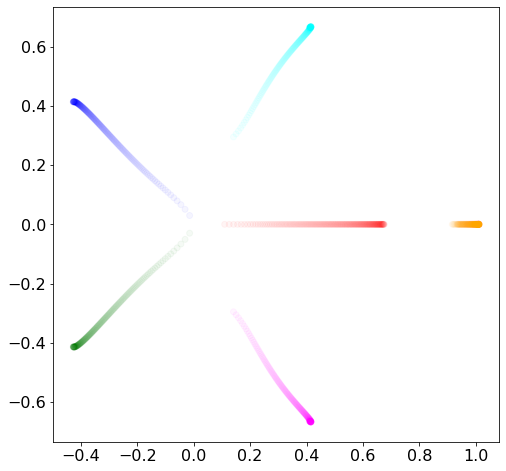

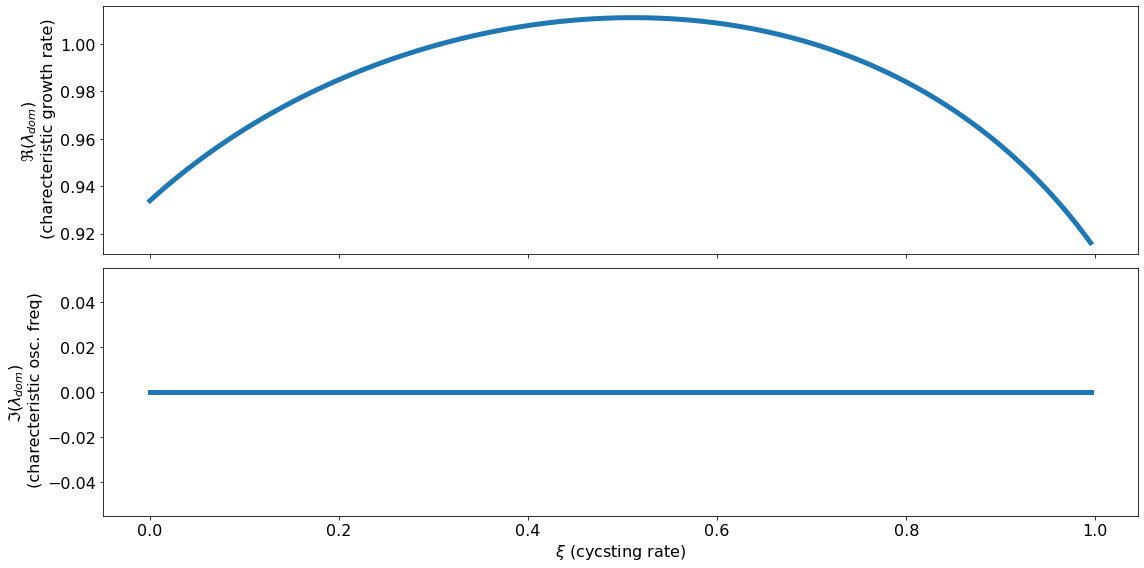

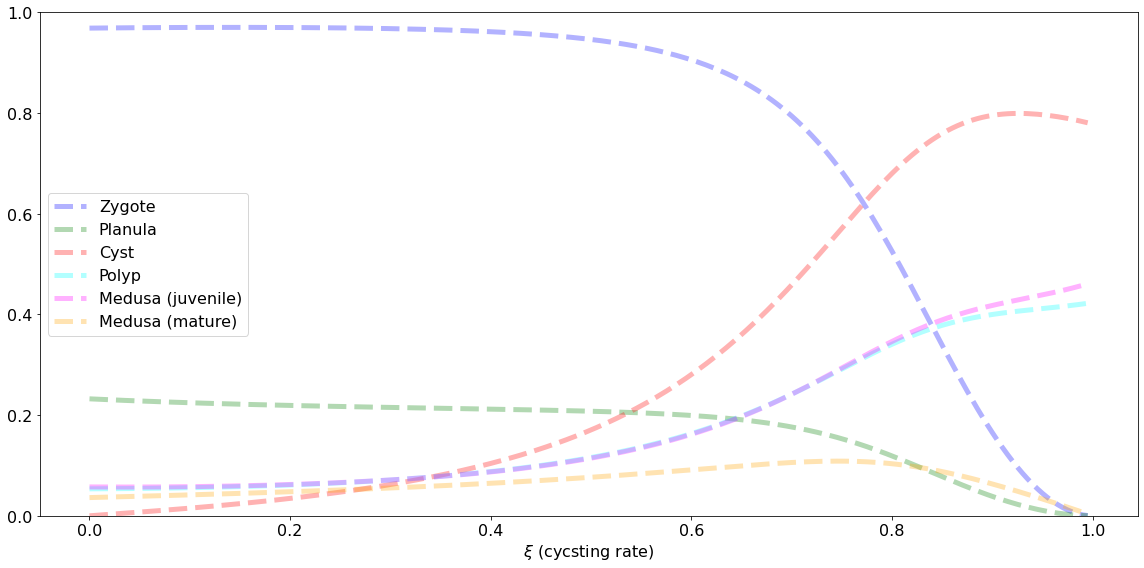

In [14]:
# Parameters: 
# TODO: use the real values
params_dict = dict(
    d1 = 0.8, # zygote
    d2 = 0.8, # planula
    d3 = 0.1,
    d4 = 0.5,
    d5 = 0.6,
    d6 = 0.6,
    t1 = 1,
    t2 = 2,
    t3 = 4,
    t4 = 4,
    t5 = 1,
    t6 = 4,
    phi = 250, 
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)

params_dict.update(
    g1 = (1-d2)*(t1-1)/t1, # zygote
    g2 = (1-d2)*(t2-1)/t2, # planula
    g3 = (1-d3)*(t3-1)/t3, # cyst
    g4 = (1-d4), # *(t4-1)/t4, # polyp
    #g5 = (1-d5)*(t5-1)/t5, # medusa (juvenile)
    #g6 = (1-d6)*(t6-1)/t6, # medusa (mature)
    h12 = (1-d1)/t1, 
    h24 = (1-d2)/t2,  
    h34 = (1-d3)/t3, 
    h45 = (1-d4)*2, #/t4,  
    #h56 = (1-d5)/t5,
    h53 = (1-d5),
    #h63 = (1-d6),
    h61 = (1-d6)/t6
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)
    print(assign_str)
    
names = ["Zygote", "Planula", "Cyst", "Polyp", "Medusa (juvenile)", "Medusa (mature)"]


L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,          phi*h61*(1-xi)], 
    [h12, g2,  0,   0,   0,          0], 
    [0,   0,   g3,  0,   h53*xi,     (1-(d6-xi))*xi], 
    [0,   h24, h34, g4,  0,          0], 
    [0,   0,   0,   h45, (1-(d5-xi))*(t5-1)/t5*(1-xi),  0], 
    [0,   0,   0,   0,   (1-(d5-xi))/t5*(1-xi),         (1-(d6-xi))*(t6-1)/t6*(1-xi)] #when they get high cysting they die less?
])

#L = lambda xi: np.array([
#    [g1,  0,   0,   0,   0,          phi*(1-d6*xi)*(1/t6)*(1-xi)], 
#    [h12, g2,  0,   0,   0,          0], 
#    [0,   0,   g3,  0,   (1-d5*xi)*xi,  (1-d6*xi)*xi], 
#    [0,   h24, h34, g4,  0,          0], 
#    [0,   0,   0,   h45, (1-d5*xi)*(t5-1)/t5*(1-xi),  0], 
#    [0,   0,   0,   0,   (1-d5*xi)/t5*(1-xi), (1-d6*xi)*(t6-1)/t6*(1-xi)]
#])

(1-d2)*(t1-1)/t1

cs = ["blue", "green", "red", "cyan", "magenta", "orange"]
ss = []
gr = []
pvs = []
xis = np.arange(0.00, 1, 0.005)
#fig, ax = plt.subplots()
eig_values_old, eig_vectors_old = None, None
for i, xi in enumerate(xis):
    
    eig_values, eig_vectors = np.linalg.eig(L(xi))
    eig_vectors = eig_vectors.T
    isort = np.argsort([abs(z) for z in eig_values])
    if i != 0:
        closest = np.array([min(eig_values, key=lambda x: np.abs(x-m)) for m in eig_values_old])
        plot_vals = closest
    else:
        plot_vals = eig_values[isort] 
    pvs.append(plot_vals)
    gr.append(eig_values[isort][-1])
    ss.append(eig_vectors[isort][-1])
    eig_values_old, eig_vectors_old = plot_vals, eig_vectors[isort]

fig, ax = plt.subplots(figsize=(8, 8))
for v in pvs:
    ax.scatter(*list(zip(*[(z.real, z.imag) for z in v])), color=cs, alpha=0.04)
plt.show()




fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax[0].plot(xis, [e.real for e in gr])
ax[1].plot(xis, [e.imag for e in gr])

ax[1].set_xlabel("$\\xi$ (cycsting rate)")
ax[0].set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate)")
ax[1].set_ylabel("$\\Im(\\lambda_{{dom}})$ \n (charecteristic osc. freq)")
plt.show()




ss = np.array(ss)
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True, tight_layout=True)
for i, e in enumerate(ss.T):
    ax.plot(xis, abs(e), linestyle="--", marker="", label=names[i], color=cs[i], alpha=0.3)
ax.set_ylim(0, 1)
ax.set_xlabel("$\\xi$ (cycsting rate)")
ax.legend()
plt.show()